In [32]:
from smartem.segmentation import segmenter, utils
from skimage import measure
from smartem.offline.train_mb_error_detector.NNtools import UNet

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp

## Set variables

In [33]:
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
device = torch.device("cuda:1")

In [34]:
model = UNet.UNet(1,2)
model_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models/unet_50_1.29e-01.pth'

In [18]:
model = smp.Unet(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=2, 
    activation='sigmoid',
)

model_path = '/home/tommy-local/projects/smartem/smartem_support/fusedem2mb/best_model_EM2MB_noslow_state.pth'

## Make Segmenter object

In [35]:
Iseg = segmenter.Segmenter(model_path, segmenter_function = measure.label, device=device)
Iseg.set_model(model_class=model)

## Compute VI vs. Dwell Time

In [23]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []

with h5py.File(data_path, "r") as f:
    for reg in f.keys():
        group = f[reg]
        mask = group["1200/mask"][()]

        gt_labels = measure.label(255 - mask)
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"1200/im"]
        hdt_labels = Iseg.get_labels(im)


        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"]

            labels = Iseg.get_labels(im)

            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
            data_gt_vois.append(voi_gt.item())
            data_hdt_vois.append(voi_hdt.item())
            data_dwts.append(int(dwt))



data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
df = pd.DataFrame(data=data)

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT (nats)'>

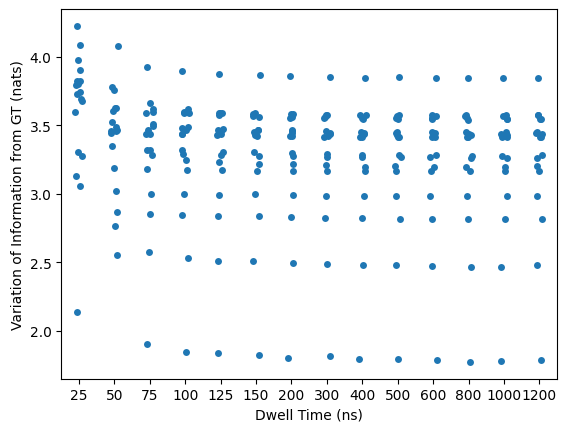

In [25]:
sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Dwell Time (ns)")

## Visualize result

In [36]:
images = {}

desired_dwts = [25, 50, 100, 400, 800, 1200]

with h5py.File("/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5", "r") as f:
    reg = list(f.keys())[2]
    group = f[reg]
    mask = group["1200/mask"][()]

    gt_labels = measure.label(255 - mask)
    gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        _, mb_probs = Iseg.get_membranes(im, get_probs=True)
        labels = Iseg.get_labels(im)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
        title_stem = f"{dwt}ns_VOI_{voi.item():.2f}"

        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = mask
images["high_dwell_time_image"] = im


Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function


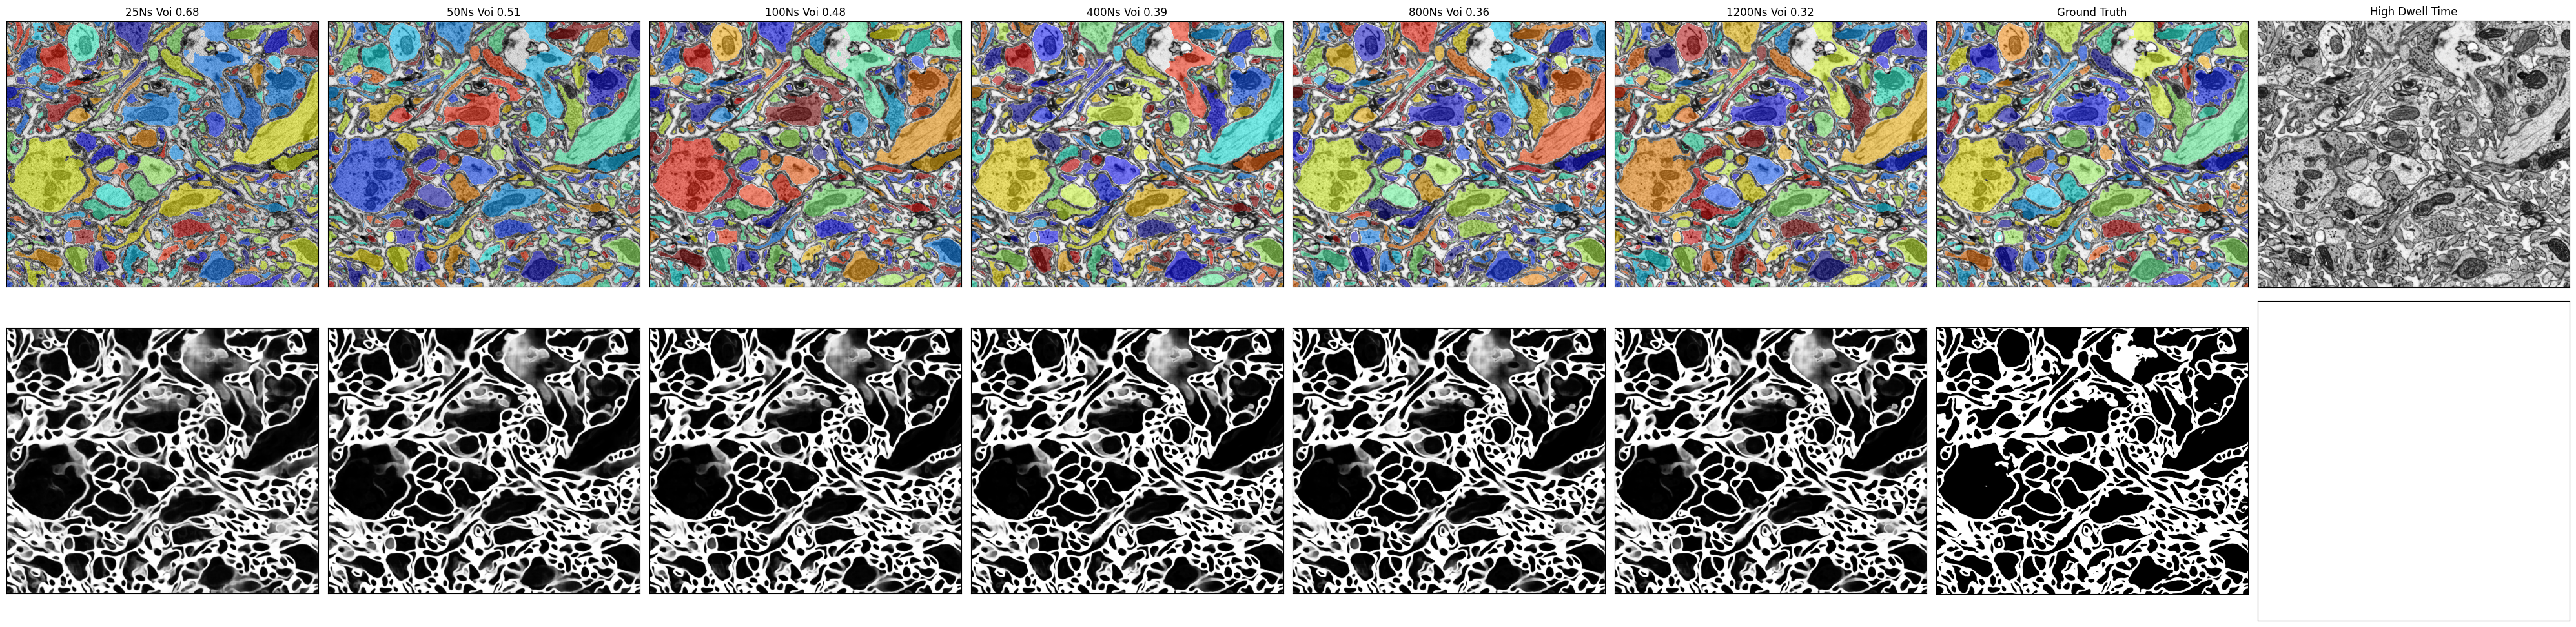

In [37]:
utils.visualize(**images)